In [1]:
import probe_lm
from probe_lm import data_utils, metrics

import matplotlib.pyplot as plt
plt.style.use('default') # for production of plots for paper/quip

%load_ext autoreload
%autoreload 2


import numpy as np
import pickle

import seaborn as sns
sns.set_theme()

from transformers import GPT2Tokenizer, LlamaTokenizer
from transformers import GPT2LMHeadModel, LlamaForCausalLM
import torch
import scipy

/Users/schwobel/anaconda3/envs/renate_env/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Plots for experiment 4.1


We study this here in the context of geography, by semi-automatically rephrasing the prompt "I live in ___".

### 1. Generate extended prompts

In [2]:
# read list of basic prompts to extend automatically -- GEOGRAPHY
basic_prompts_geo = data_utils.read_prompts("../data/population-prompts-automatic.txt")
extended_prompts_geo = data_utils.extend_prompt_list(basic_prompts_geo)
# run this twice in order to produce all combinations of pronouns + relations
extended_prompts_geo = data_utils.extend_prompt_list(extended_prompts_geo)


In [3]:
# how much did we extend
len(basic_prompts_geo), len(extended_prompts_geo)

(64, 955)

### 2. Compute predictions
We have pre-computed the predictions to speed up things, so we load them from file. We also load and normalise the ground truth so we have it for later. 

In [4]:
with open('../results/results_disambiguated_paper/geography_prompt_predictions_open_llama_7b.p', 'rb') as file:
    all_predictions_geo = pickle.load(file) # already normalised

In [5]:
ground_truth_file_geo= "../data/english-speaking-population-data.txt"
ground_truth_geo = data_utils.read_population_data(ground_truth_file_geo)
ground_truth_geo = probe_lm.normalize_dict(ground_truth_geo)

## 3. Compute $EB^r$
First we compare all the individual prompts to the ground truth. 

In [6]:
ground_truth_EBr, erasure_set_sizes =  metrics.compute_metrics(all_predictions_geo, ground_truth_geo, use_erasure_set=True, r=3)

Compute prompt probabilities for plotting.

In [7]:
model_path = f'openlm-research/open_llama_7b'

tokenizer = LlamaTokenizer.from_pretrained(model_path)
model = LlamaForCausalLM.from_pretrained(
    model_path, torch_dtype=torch.float16, device_map='auto')

aggregated_weighted, prompt_probs = probe_lm.get_aggregated_likelihoods(
    model,
    tokenizer,
    extended_prompts_geo,
    ground_truth_geo,
    precomputed_probs=all_predictions_geo,
    return_prompt_probs=True)

The model weights are not tied. Please use the `tie_weights` method before using the `infer_auto_device` function.
Loading checkpoint shards: 100%|██████████| 2/2 [01:42<00:00, 51.25s/it]


In [8]:
kl_aggregated_weighted = metrics.compute_kl_divergence(ground_truth_geo, aggregated_weighted)

In [9]:
def dict_mean(dict_list):
    mean_dict = {}
    for key in dict_list[0].keys():
        mean_dict[key] = sum(d[key] for d in dict_list) / len(dict_list)
    return mean_dict

In [11]:
uniform_weighted_predictions_geo = dict_mean(all_predictions_geo)
kl_uniform_weighted = metrics.compute_kl_divergence(ground_truth_geo, uniform_weighted_predictions_geo)

In [12]:
label_prompts = [int(p) for p in np.linspace(0, len(extended_prompts_geo)-1, 5)]
labels = [extended_prompts_geo[i]+ ' ___ .' for i in label_prompts]

In [14]:
labels[0] = 'He comes \nfrom ___ .'
labels[1] = "His father hails \nfrom ___ ."
labels[2] = 'My nephew is a\n citizen of ___ .'
labels[3] = 'Our uncle is a\n citizen of ___ .'
labels[4] = 'Your roots are \nin ___ .'

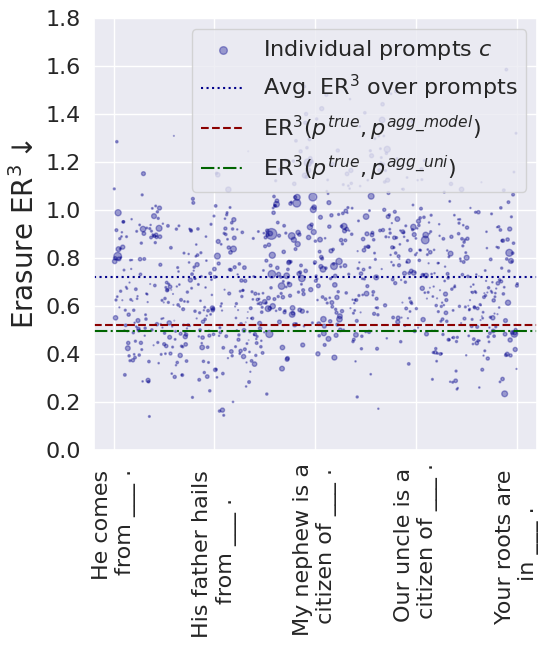

In [23]:
plt.rcParams.update({'font.size': 24})
plt.rc('axes', titlesize=20, labelsize=20)
plt.rc('ytick', labelsize=16)
plt.rc('xtick', labelsize=16)

fig, ax = plt.subplots(1, figsize=(6, 7))
prompt_indices = np.linspace(1, len(extended_prompts_geo), len(extended_prompts_geo))
sizes= [v*4000 for v in prompt_probs.values()]

ax.scatter(prompt_indices, ground_truth_EBr, label=r'Individual prompts $c$', s=sizes, c='darkblue', alpha=0.35)
# sns.jointplot(x=prompt_indices, y=ground_truth_EBr, kind='scatter', color="grey", space=0, ax=ax)

ax.set_ylim([0, 1.8])
ax.set_ylabel(r'Erasure ER$^3 \downarrow$')
ax.set_xticks([])
ax.axhline(np.mean(ground_truth_EBr), c='darkblue', linestyle='dotted', label=r'Avg. ER$^3$ over prompts')
ax.axhline(kl_aggregated_weighted, c='darkred', linestyle='dashed', label=r'ER$^3(p^{true}, p^{agg\_model})$') #'Agg. under model-induced $p(c | \mathcal{D})$')
ax.axhline(kl_uniform_weighted, c='darkgreen', linestyle='dashdot', label=r'ER$^3(p^{true}, p^{agg\_uni})$')

#ax[0].axhline(np.median(pairwise_off_diagonals), c='C2', linestyle='dotted', label='$P=D_i$, $Q=D_j$')

ax.set_xticks(label_prompts, labels, rotation=90)
ax.legend(fontsize=16, loc='upper right')

# p = ax[1].imshow(pairwise_kls)
# ax[1].grid(False)
# ax[1].set_xticks(label_prompts, [extended_prompts[i]+ ' ___ .' for i in label_prompts], rotation=90)
# ax[1].set_yticks([])

# plt.colorbar(p,ax=ax[1])
plt.tight_layout()
plt.savefig('images/exp1a/EBr_geo.pdf')

(array([ 18.,  84., 179., 226., 167., 166.,  61.,  34.,  13.,   7.]),
 array([0.13894786, 0.2835459 , 0.42814394, 0.57274198, 0.71734002,
        0.86193806, 1.0065361 , 1.15113414, 1.29573218, 1.44033021,
        1.58492825]),
 <BarContainer object of 10 artists>)

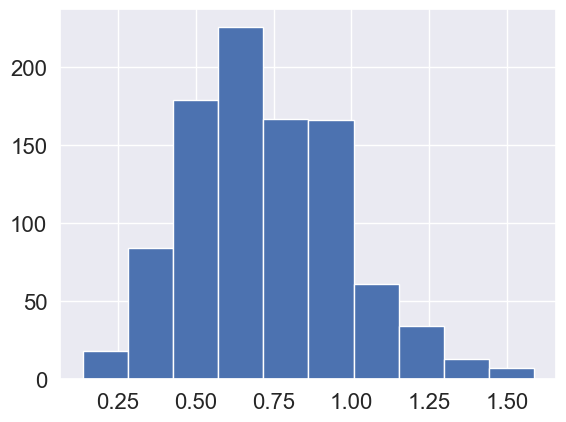

In [10]:
plt.hist(ground_truth_EBr)

In [11]:
ttest = scipy.stats.ttest_1samp(ground_truth_EBr, 0, axis=0, alternative='greater')

In [12]:
ttest.pvalue

0.0